In [2]:
import copy
import peft
import torch
from torch import nn
import torch.nn.functional as F
from torchview import draw_graph

In [1]:
import graphviz
graphviz.set_jupyter_format('png')
from torchview import draw_graph

In [3]:
class MLP(nn.Module):
    def __init__(self, num_units_hidden=2000):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(20, num_units_hidden),
            nn.ReLU(),
            nn.Linear(num_units_hidden, num_units_hidden),
            nn.ReLU(),
            nn.Linear(num_units_hidden, 2),
            nn.LogSoftmax(dim=-1),
        )

    def forward(self, X):
        return self.seq(X)

In [4]:
X = torch.rand((1000, 20))
y = (X.sum(1) > 10).long()

In [5]:
n_train = 800
batch_size = 64
max_epochs = 30
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

In [6]:
train_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X[:n_train], y[:n_train]),
    batch_size=batch_size,
    shuffle=True,
)

In [7]:
config = peft.LoraConfig(
    r=8,
    target_modules=["seq.0", "seq.2"],
    modules_to_save=["seq.4"],
)

In [16]:
module = MLP().to(device)
orig_module = copy.deepcopy(module)
peft_model = peft.get_peft_model(module, config)
criterion = nn.CrossEntropyLoss()

In [9]:
batch = next(iter(train_dataloader))
batch = [x.cuda() for x in batch]

In [10]:
def step(model,batch):
    xb=batch[0]
    yb=batch[1]
    outputs = model(xb)
    loss = criterion(outputs, yb)
    return loss

In [11]:
print(step(module,batch))

tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward0>)


In [12]:
print(step(peft_model,batch))

tensor(0.6955, device='cuda:0', grad_fn=<NllLossBackward0>)


In [17]:
print(step(orig_module,batch))

tensor(0.6884, device='cuda:0', grad_fn=<NllLossBackward0>)


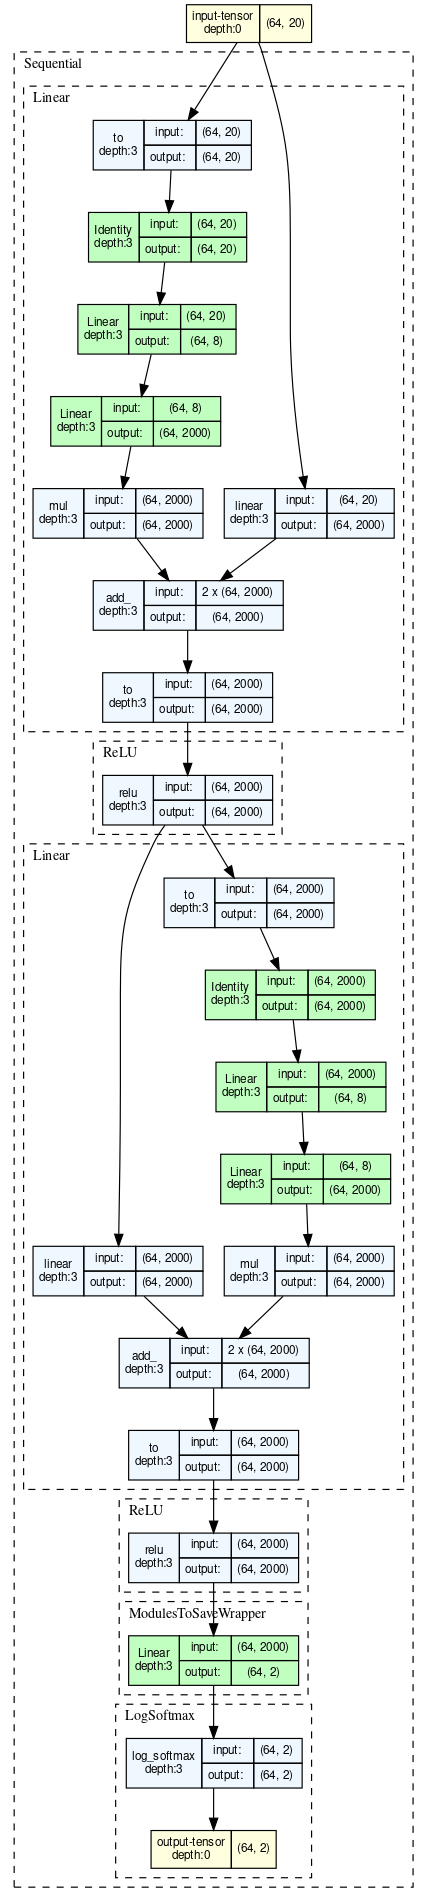

In [13]:
draw_graph(module, input_data=batch[0], 
           device='meta',
           expand_nested=True,
           hide_module_functions=False,).visual_graph

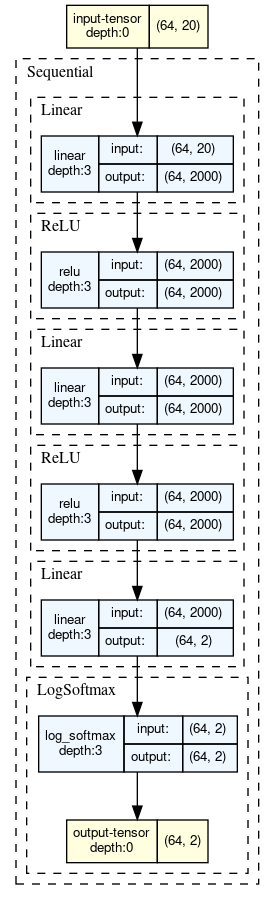

In [18]:
draw_graph(orig_module, input_data=batch[0], 
           device='meta',
           expand_nested=True,
           hide_module_functions=False,).visual_graph